<a href="https://colab.research.google.com/github/naufalfrdss/DeepLearning/blob/main/UAS/Chapter%2018/Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔁 Reinforcement Learning (RL) - Ringkasan Kompleks Singkat

## 🧠 Konsep Inti RL

- **Agent**: Entitas yang belajar dari pengalaman (contoh: robot, AI).
- **Environment**: Dunia tempat agent berinteraksi (misal: `CartPole`, `LunarLander`).
- **State (`s`)**, **Action (`a`)**, **Reward (`r`)**: Unit interaksi utama antara agent dan environment.
- **Policy (`π(a|s)`)**: Strategi agent untuk memilih aksi berdasarkan state.
- **Return (`G_t`)**: Total reward kumulatif yang didiskonto dari waktu `t`.
- **Objective**: Memaksimalkan fungsi objektif:
  $
  \[
  J(θ) = \mathbb{E}[G_t]
  \]
  $
  dengan mengoptimasi parameter policy `θ`.

---

## 📌 Algoritma: Policy Gradient

- **Tujuan**: Mempelajari parameter `θ` yang memaksimalkan expected return.
- **Rumus Gradien**:

  $\[
  \nabla J(θ) = \mathbb{E}_{π_θ} \left[ \nabla_θ \log π_θ(a|s) \cdot G_t \right]
  $\]

- **Pendekatan**:
  - Monte Carlo estimation untuk menghitung `G_t`.
  - Gradient ascent untuk memperbarui `θ`.
  - Digunakan dalam algoritma seperti REINFORCE.

---

> Cocok digunakan pada masalah dengan action space diskrit dan episode berdurasi pendek.


Setup dan Environment

In [1]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

env = gym.make("CartPole-v1")
n_inputs = env.observation_space.shape[0]
n_actions = env.action_space.n


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Neural Network Policy

In [2]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(n_inputs,)),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(n_actions, activation="softmax")
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


Discounted Rewards

In [3]:
def discount_rewards(rewards, gamma=0.95):
    discounted = np.zeros_like(rewards, dtype=np.float32)
    running_add = 0
    for t in reversed(range(len(rewards))):
        running_add = rewards[t] + gamma * running_add
        discounted[t] = running_add
    discounted -= np.mean(discounted)
    discounted /= (np.std(discounted) + 1e-8)
    return discounted


Episode Simulation & Gradient Calculation

In [8]:
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

In [13]:
def play_episode(env, model, gamma=0.95):
    state = env.reset()
    rewards, grads = [], []
    done = False

    while not done:
        with tf.GradientTape() as tape:
            state_input = tf.convert_to_tensor([state], dtype=tf.float32)
            probs = model(state_input, training=True)
            action = np.random.choice(n_actions, p=np.squeeze(probs))
            loss = tf.keras.losses.sparse_categorical_crossentropy(
                tf.convert_to_tensor([action]), probs
            )

        grads.append(tape.gradient(loss, model.trainable_variables))
        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        state = next_state

    discounted = discount_rewards(rewards, gamma)
    return grads, discounted, sum(rewards)

Training Loop

In [14]:
n_iterations = 100
n_episodes_per_update = 10
all_mean_rewards = []

In [15]:
for iteration in range(n_iterations):
    all_grads = []
    total_reward = 0

    for _ in range(n_episodes_per_update):
        grads, discounted, reward_sum = play_episode(env, model)
        total_reward += reward_sum
        for grad, disc in zip(grads, discounted):
            all_grads.append([g * disc for g in grad])

    mean_reward = total_reward / n_episodes_per_update
    all_mean_rewards.append(mean_reward)

    # Mean of all grads
    mean_grads = [tf.reduce_mean([g[i] for g in all_grads if g[i] is not None], axis=0)
                  for i in range(len(model.trainable_variables))]

    optimizer.apply_gradients(zip(mean_grads, model.trainable_variables))
    print(f"Iter {iteration + 1}: Mean Reward = {mean_reward:.2f}")

Iter 1: Mean Reward = 153.40
Iter 2: Mean Reward = 159.90
Iter 3: Mean Reward = 152.90
Iter 4: Mean Reward = 157.40
Iter 5: Mean Reward = 177.60
Iter 6: Mean Reward = 206.30
Iter 7: Mean Reward = 269.20
Iter 8: Mean Reward = 326.10
Iter 9: Mean Reward = 423.00
Iter 10: Mean Reward = 483.70
Iter 11: Mean Reward = 500.00
Iter 12: Mean Reward = 458.30
Iter 13: Mean Reward = 499.00
Iter 14: Mean Reward = 493.00
Iter 15: Mean Reward = 500.00
Iter 16: Mean Reward = 500.00
Iter 17: Mean Reward = 495.10
Iter 18: Mean Reward = 492.50
Iter 19: Mean Reward = 464.00
Iter 20: Mean Reward = 494.80
Iter 21: Mean Reward = 466.30
Iter 22: Mean Reward = 468.00
Iter 23: Mean Reward = 491.70
Iter 24: Mean Reward = 500.00
Iter 25: Mean Reward = 500.00
Iter 26: Mean Reward = 500.00
Iter 27: Mean Reward = 500.00
Iter 28: Mean Reward = 500.00
Iter 29: Mean Reward = 500.00
Iter 30: Mean Reward = 491.10
Iter 31: Mean Reward = 500.00
Iter 32: Mean Reward = 500.00
Iter 33: Mean Reward = 500.00
Iter 34: Mean Rewar

Visualisasi

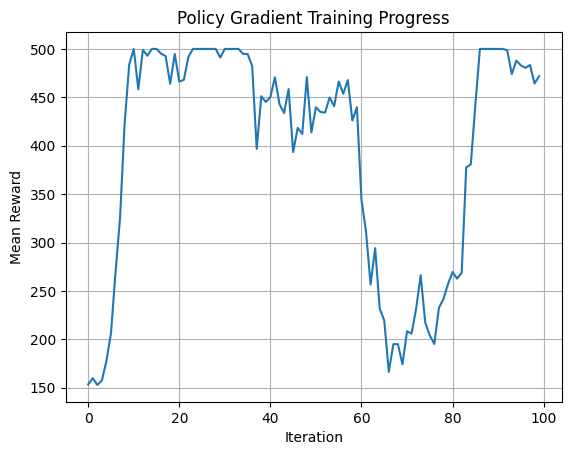

In [16]:
plt.plot(all_mean_rewards)
plt.xlabel("Iteration")
plt.ylabel("Mean Reward")
plt.title("Policy Gradient Training Progress")
plt.grid(True)
plt.show()
